# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

/home/jorge/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [3]:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
customers.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [5]:
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [6]:
customers.corr()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


In [7]:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [8]:
customers.Region.value_counts()

3    316
1     77
2     47
Name: Region, dtype: int64

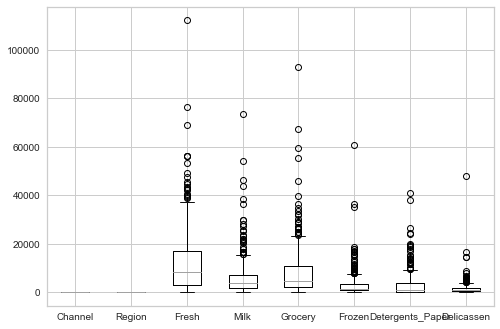

In [9]:
customers.boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80e3d2f5c0>,
      dtype=object)

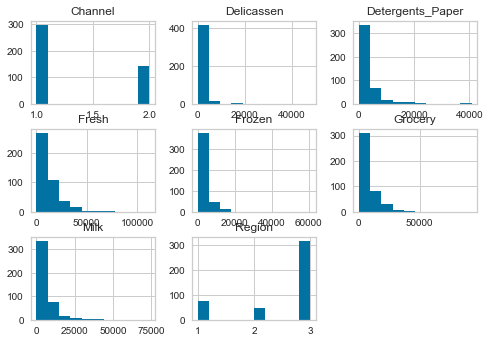

In [10]:
customers.hist()

In [11]:
#Existe una gran coorrelación entre groceries y detergente_paper.
#Sería conveniente normalizar las distribución de los datos dando que no es normal y tienen muchos outliers
#Por el resto, creo que los datos están bien, dado que todas las columnas tiene el type correcto y
#no hay que hacer limpieza de esos números

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [12]:
pipeline = [
    StandardScaler()
]

tr = make_pipeline(*pipeline)

Xpr = tr.fit_transform(customers)
customers_scale = pd.DataFrame(Xpr,columns=customers.columns)

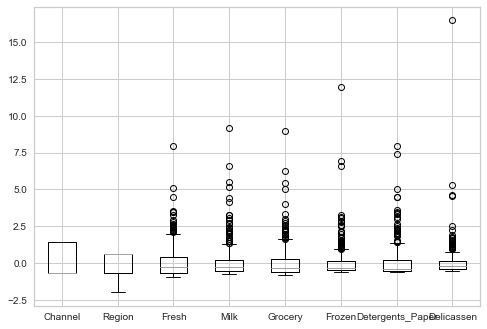

In [13]:
customers_scale.boxplot()

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [14]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:


# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [15]:
customers_scale

model = KMeans()

labels = model.fit_predict(customers_scale)

customers["label"] = labels
customers.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,label
0,2,3,12669,9656,7561,214,2674,1338,1
1,2,3,7057,9810,9568,1762,3293,1776,1
2,2,3,6353,8808,7684,2405,3516,7844,1
3,1,3,13265,1196,4221,6404,507,1788,3
4,2,3,22615,5410,7198,3915,1777,5185,1


Count the values in `labels`.

In [16]:
customers.label.value_counts()

3    175
1     93
0     86
7     41
5     37
4      5
6      2
2      1
Name: label, dtype: int64

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [31]:
clustering = DBSCAN(eps=0.5)

labels = clustering.fit_predict(customers_scale)

customers["labels_DBSCAN"] = labels
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,label,labels_DBSCAN
0,2,3,12669,9656,7561,214,2674,1338,1,-1
1,2,3,7057,9810,9568,1762,3293,1776,1,-1
2,2,3,6353,8808,7684,2405,3516,7844,1,-1
3,1,3,13265,1196,4221,6404,507,1788,3,1
4,2,3,22615,5410,7198,3915,1777,5185,1,-1


Count the values in `labels_DBSCAN`.

In [18]:
customers["labels_DBSCAN"].value_counts()


-1    255
 1    130
 5     22
 4      7
 6      6
 2      5
 7      5
 3      5
 0      5
Name: labels_DBSCAN, dtype: int64

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

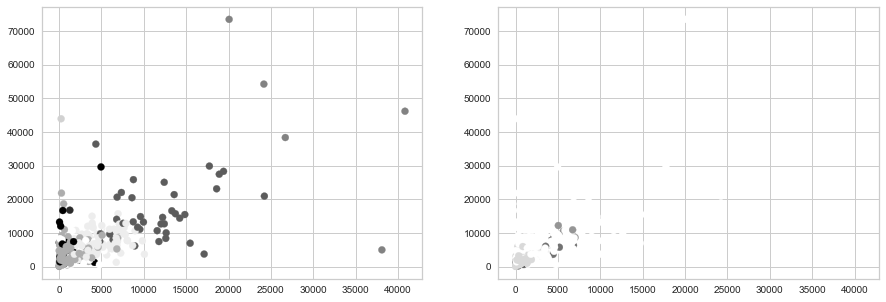

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(customers["Detergents_Paper"],customers["Milk"],c=customers.label)
ax[1].scatter(customers["Detergents_Paper"],customers["Milk"],c=customers.labels_DBSCAN)

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

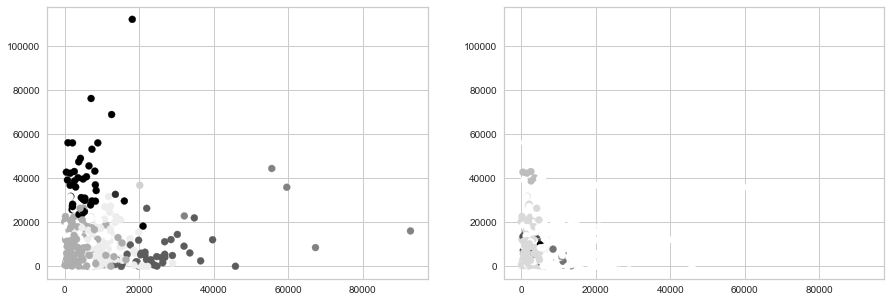

In [20]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(customers["Grocery"],customers["Fresh"],c=customers.label)
ax[1].scatter(customers["Grocery"],customers["Fresh"],c=customers.labels_DBSCAN)

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

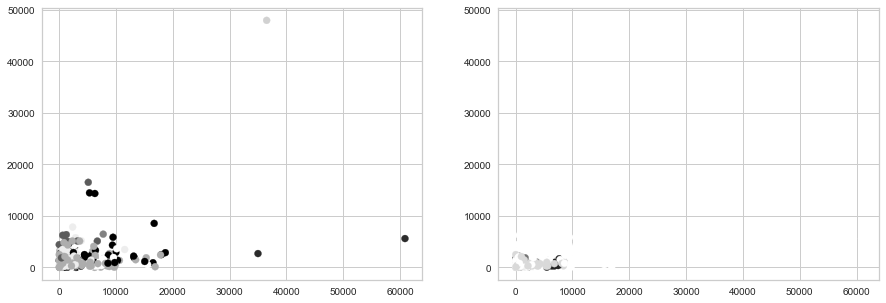

In [21]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(customers["Frozen"],customers["Delicassen"],c=customers.label)
ax[1].scatter(customers["Frozen"],customers["Delicassen"],c=customers.labels_DBSCAN)

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [22]:
customers.groupby(["label"]).mean()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels_DBSCAN
label,,,,,,,,,
0,1.05814,1.302326,10201.197674,3264.127907,4152.860465,3114.360465,914.034884,1084.197674,1.488372
1,2.00000,2.860215,8663.322581,7383.720430,11361.247312,1469.215054,4711.569892,1442.569892,-0.354839
2,1.00000,3.000000,36847.000000,43950.000000,20170.000000,36534.000000,239.000000,47943.000000,-1.000000
3,1.00000,3.000000,8816.377143,2952.085714,3427.154286,2680.851429,774.268571,1006.748571,0.462857
4,2.00000,2.800000,25603.000000,43460.600000,61472.200000,2636.000000,29974.200000,2708.800000,-1.000000
5,2.00000,2.162162,5694.540541,15773.594595,24499.594595,1707.918919,11545.189189,2463.081081,-1.000000
6,1.00000,2.500000,22015.500000,9937.000000,7844.000000,47939.000000,671.500000,4153.500000,-1.000000
7,1.04878,2.780488,39870.292683,4916.853659,5740.585366,6566.926829,901.268293,2595.951220,-0.536585


In [23]:
customers.groupby(["labels_DBSCAN"]).mean()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,label
labels_DBSCAN,,,,,,,,,
-1,1.490196,2.45098,13729.564706,8359.886275,11484.364706,3795.003922,4356.800000,2080.470588,2.643137
0,2.000000,3.00000,11401.000000,3536.200000,6729.000000,720.200000,3561.000000,258.200000,1.000000
1,1.000000,3.00000,9128.823077,1862.438462,2423.530769,2131.430769,496.576923,741.946154,3.061538
2,1.000000,3.00000,41446.600000,1421.200000,2167.600000,1276.400000,416.200000,784.800000,7.000000
3,2.000000,3.00000,2357.200000,10224.800000,11862.800000,609.600000,5780.000000,572.800000,1.000000
4,2.000000,3.00000,3068.142857,6095.857143,10355.000000,994.000000,4675.571429,1826.428571,1.000000
5,1.000000,1.00000,9837.863636,1751.863636,2161.681818,1513.181818,333.954545,669.045455,0.000000
6,1.000000,1.00000,6823.000000,1943.000000,2372.666667,6780.333333,386.500000,613.666667,0.000000
7,1.000000,2.00000,7494.600000,1537.600000,3383.000000,2575.400000,227.400000,941.000000,0.000000


Which algorithm appears to perform better?

In [24]:
# No lo se

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

/home/jorge/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f80e3445e48>,
                 k=None, metric='silhouette', model=None, timings=False)

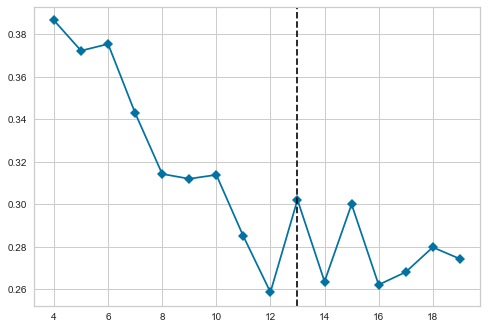

In [25]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,20), metric="silhouette", timings=False)

visualizer.fit(customers)

In [28]:
#13 será el más adecuado

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [32]:
clustering = DBSCAN(eps=0.5, min_samples= 10)

labels = clustering.fit_predict(customers_scale)

customers["labels_DBSCAN_2"] = labels
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,label,labels_DBSCAN,labels_DBSCAN_2
0,2,3,12669,9656,7561,214,2674,1338,1,-1,-1
1,2,3,7057,9810,9568,1762,3293,1776,1,-1,-1
2,2,3,6353,8808,7684,2405,3516,7844,1,-1,-1
3,1,3,13265,1196,4221,6404,507,1788,3,1,-1
4,2,3,22615,5410,7198,3915,1777,5185,1,-1,-1
